In [1]:
# TODO
# check how test gone /n
# features from volume
# do separate notebook to testing algo with GPU
# use values from day before
# features from data
# Shorting dividend days = easy score boost https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/discussion/320836

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Functions

In [3]:
from decimal import ROUND_HALF_UP, Decimal
def adjust_price(price):
    """
    We will generate AdjustedClose using AdjustmentFactor value. 
    This should reduce historical price gap caused by split/reverse-split.
    
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        
        # generate AdjustedClose
        df.loc[:, "Close"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["Close"] == 0, "Close"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "Close"] = df.loc[:, "Close"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [4]:
def adjust_col(df):
    df = df.sort_values(by=['SecuritiesCode', 'Date'])
    
    changes = df[df.AdjustmentFactor != 1.0]
    df['AFoverall'] = 1.0

    for index, row in changes.iterrows():
#         print(row.Date, row.AdjustmentFactor)
        df.loc[((df['Date'] > row.Date) & (df['SecuritiesCode'] == row.SecuritiesCode)), 'AFoverall'] = df.AFoverall / row.AdjustmentFactor

    df.Close = df.Close * df.AFoverall
    df.High = df.High * df.AFoverall
    df.Low = df.Low * df.AFoverall
    df.Open = df.Open * df.AFoverall

    return df

In [5]:
def feature_engineering(df):
    # Dates
#     df['dayofweek'] = df.Date.dt.dayofweek
#     df['week'] = df.Date.dt.week
#     df['month'] = df.Date.dt.month
#     df['year'] = df.Date.dt.year
#     df = df.drop('Date', axis=1)
    
    df['CloseMinusOpen'] = df.Close - df.Open
    df['CloseDivOpen'] = df.Close / df.Open
    df['HighMinusLow'] = df.High - df.Low
    df['HighDivLow'] = df.High / df.Low
    df['HighDivClose'] = df.High / df.Close
    df['LowDivClose'] = df.Low / df.Close
    
    df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    
    # https://www.kaggle.com/code/lucasmorin/jpx-online-feature-engineering-prices
    df['Avg_Price'] = (df['Close']+df['Open'])/2
    df['Avg_Price_HL'] = (df['High']+df['Low'])/2
    df['Side'] = 2*(df['Avg_Price']-df['Avg_Price_HL'])/(df['High']-df['Low'])
    
    df['ret_H'] = df['High']/df['Open']-1
    df['ret_L'] = df['Low']/df['Open']-1
    df['ret'] = df['Close']/df['Open']-1
#     df['ret_Div'] = df['ExpectedDividend']/df['Open']
    
    df['log_Dollars'] = np.log(df['Avg_Price']*df['Volume'])
    
    df['GK_sqrt_vol'] = np.sqrt((1 / 2 * np.log(df['High']/df['Low']) ** 2 - (2 * np.log(2) - 1) * np.log(df['Close'] / df['Open']) ** 2))
    df['RS_sqrt_vol'] = np.sqrt(np.log(df['High']/df['Close'])*np.log(df['High']/df['Open']) + np.log(df['Low']/df['Close'])*np.log(df['Low']/df['Open']))
    # https://www.kaggle.com/code/lucasmorin/jpx-online-feature-engineering-prices
#     # https://www.kaggle.com/code/satoshidatamoto/1st-place-of-jane-street-adapted-to-jpx
# #     df['shadow1'] = df['trade'] / df['Volume']
#     df['shadow3'] = df['Upper_Shadow'] / df['Volume']
#     df['shadow5'] = df['Lower_Shadow'] / df['Volume']    
#     df['mean1'] = (df['shadow5'] + df['shadow3']) / 2
# #     df['mean2'] = (df['shadow1'] + df['Volume']) / 2
#     # https://www.kaggle.com/code/satoshidatamoto/1st-place-of-jane-street-adapted-to-jpx
    return df

In [6]:
def fill_na(df):
    df['Open'] = df['Open'].fillna(method='bfill')
    df['High'] = df['High'].fillna(method='bfill')
    df['Low'] = df['Low'].fillna(method='bfill')
    df['Close'] = df['Close'].fillna(method='bfill')
    return df

In [7]:
from sklearn.preprocessing import OrdinalEncoder

def preprocess(prices, options=None, financials=None, trades=None, secondary_prices=None, sample_prediction=None):
#     prices = adjust_col(prices)
    prices = adjust_price(prices)
#     prices['Date'] = pd.to_datetime(prices['Date'])
    features = ["SecuritiesCode", "Open", "High", "Low", "Close", 'Volume']#, 'AdjustmentFactor']
    prices = prices.loc[:,features]
    
    prices = fill_na(prices)
#     if 'ExpectedDividend' in prices:
#         prices = prices.drop("ExpectedDividend", axis=1)
        
    enc = OrdinalEncoder()
    prices["SecuritiesCode"] = enc.fit_transform(prices[["SecuritiesCode"]])
    
    prices = feature_engineering(prices)
    return prices

## Data

In [8]:
p_train = '../input/jpx-tokyo-stock-exchange-prediction/train_files/'
p_supp = '../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/'

In [9]:
stock_list = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')
prices = pd.read_csv((p_train + 'stock_prices.csv'),
                    parse_dates=['Date'])
prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [10]:
preprocess(prices)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,SecuritiesCode,Open,High,Low,Close,Volume,CloseMinusOpen,CloseDivOpen,HighMinusLow,HighDivLow,...,Lower_Shadow,Avg_Price,Avg_Price_HL,Side,ret_H,ret_L,ret,log_Dollars,GK_sqrt_vol,RS_sqrt_vol
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.0,2734.0,2755.0,2730.0,2742.0,31400,8.0,1.002926,25.0,1.009158,...,4.0,2738.0,2742.5,-0.360000,0.007681,-0.001463,0.002926,18.269546,0.006185,0.006528
2017-01-05,0.0,2743.0,2747.0,2735.0,2738.0,17900,-5.0,0.998177,12.0,1.004388,...,3.0,2740.5,2741.0,-0.083333,0.001458,-0.002917,-0.001823,17.708452,0.002881,0.002826
2017-01-06,0.0,2734.0,2744.0,2720.0,2740.0,19900,6.0,1.002195,24.0,1.008824,...,14.0,2737.0,2732.0,0.416667,0.003658,-0.005121,0.002195,17.813093,0.006061,0.006553
2017-01-10,0.0,2745.0,2754.0,2735.0,2748.0,24200,3.0,1.001093,19.0,1.006947,...,10.0,2746.5,2744.5,0.210526,0.003279,-0.003643,0.001093,18.012191,0.004848,0.004944
2017-01-11,0.0,2748.0,2752.0,2737.0,2745.0,9300,-3.0,0.998908,15.0,1.005480,...,8.0,2746.5,2744.5,0.266667,0.001456,-0.004003,-0.001092,17.055852,0.003805,0.003926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,1999.0,678.0,679.0,665.0,668.0,320800,-10.0,0.985251,14.0,1.021053,...,3.0,673.0,672.0,0.142857,0.001475,-0.019174,-0.014749,19.190318,0.011478,0.010546
2021-11-30,1999.0,670.0,689.0,667.0,667.0,296300,-3.0,0.995522,22.0,1.032984,...,0.0,668.5,678.0,-0.863636,0.028358,-0.004478,-0.004478,19.104164,0.022776,0.030124
2021-12-01,1999.0,661.0,688.0,660.0,685.0,339100,24.0,1.036309,28.0,1.042424,...,1.0,673.0,674.0,-0.071429,0.040847,-0.001513,0.036309,19.245796,0.019282,0.015207


### Drop na

In [11]:
prices.dtypes

RowId                       object
Date                datetime64[ns]
SecuritiesCode               int64
Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                       int64
AdjustmentFactor           float64
ExpectedDividend           float64
SupervisionFlag               bool
Target                     float64
dtype: object

In [12]:
prices.isnull().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

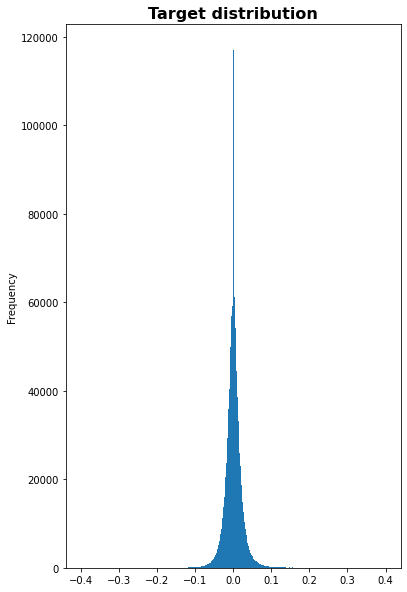

In [13]:
prices['Target'].plot(kind='hist', bins=800,range=[-0.4,0.4], figsize=(6, 10));
plt.title("Target distribution", weight='bold', fontsize=16);

In [14]:
from sklearn.model_selection import train_test_split

split_size = 0.05

X = preprocess(prices)
y = prices[['Target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=split_size)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Model

### LGBM

In [15]:
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error

# model = LGBMRegressor()
# model.fit(X_train, y_train)
# val_preds = model.predict(X_val)
# val_score = np.sqrt(mean_squared_error(y_val, val_preds))
# print(val_score)

In [16]:
import optuna
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

seed = 2
n_trials = 15

def optimize_LGBM():
    def objectives(trial):
        params = {
                'num_leaves': trial.suggest_int('num_leaves', 300, 4000),
                'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
                'max_bin': trial.suggest_int('max_bin', 2, 2000),
                'learning_rate': trial.suggest_uniform('learning_rate',0, 1),
                'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

        model = LGBMRegressor(**params)
        model.fit(X_train,y_train)
        val_preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, val_preds))
    #     score = model.score(X_val,y_val)
        return score

    opt = optuna.create_study(direction='minimize',sampler=optuna.samplers.RandomSampler(seed=seed))
    opt.optimize(objectives, n_trials=n_trials)

    trial = opt.best_trial
    params_best = dict(trial.params.items())
    params_best['random_seed'] = seed
    model = LGBMRegressor(**params_best)
    return model

Trial 0 finished with value: 0.02296859284303052 and parameters: {'num_leaves': 3351, 'n_estimators': 189, 'max_bin': 1755, 'learning_rate': 0.4995513073466392, 'lambda_l1': 4.834347879418099, 'lambda_l2': 1.0762419629346587e-08, 'feature_fraction': 0.9541866079830311, 'bagging_fraction': 0.7776663479407265, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 0 with value: 0.02296859284303052.

[I 2022-05-02 18:14:51,752] A new study created in memory with name: no-name-ffff9fc9-2c94-436d-959c-a17944d6fa1b


[LightGBM] [Warning] lambda_l1 is set=6.071698793016848e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.071698793016848e-05
[LightGBM] [Warning] bagging_fraction is set=0.7715625798103982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715625798103982
[LightGBM] [Warning] lambda_l2 is set=9.397522821096242e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.397522821096242e-06
[LightGBM] [Warning] feature_fraction is set=0.5227891804227055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227891804227055
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-05-02 18:15:13,910] Trial 0 finished with value: 0.026371879492215936 and parameters: {'num_leaves': 1913, 'n_estimators': 35, 'max_bin': 1100, 'learning_rate': 0.4353223926182769, 'lambda_l1': 6.071698793016848e-05, 'lambda_l2': 9.397522821096242e-06, 'feature_fraction': 0.5227891804227055, 'bagging_fraction': 0.7715625798103982, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=4.570448196536859e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.570448196536859e-07
[LightGBM] [Warning] bagging_fraction is set=0.6965421024291567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6965421024291567
[LightGBM] [Warning] lambda_l2 is set=0.11695433673868773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11695433673868773
[LightGBM] [Warning] feature_fraction is set=0.9123851755836933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9123851755836933
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-05-02 18:18:49,866] Trial 1 finished with value: 0.030077234284358267 and parameters: {'num_leaves': 2598, 'n_estimators': 534, 'max_bin': 271, 'learning_rate': 0.5135781212657464, 'lambda_l1': 4.570448196536859e-07, 'lambda_l2': 0.11695433673868773, 'feature_fraction': 0.9123851755836933, 'bagging_fraction': 0.6965421024291567, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=1.3945681596725894e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3945681596725894e-07
[LightGBM] [Warning] bagging_fraction is set=0.4641674105859898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4641674105859898
[LightGBM] [Warning] lambda_l2 is set=0.002348052379716787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002348052379716787
[LightGBM] [Warning] feature_fraction is set=0.5356072003625415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5356072003625415
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-05-02 18:19:33,513] Trial 2 finished with value: 0.027839743189513946 and parameters: {'num_leaves': 2169, 'n_estimators': 74, 'max_bin': 857, 'learning_rate': 0.09653091566061256, 'lambda_l1': 1.3945681596725894e-07, 'lambda_l2': 0.002348052379716787, 'feature_fraction': 0.5356072003625415, 'bagging_fraction': 0.4641674105859898, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=0.0003524767538465575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003524767538465575
[LightGBM] [Warning] bagging_fraction is set=0.748002507326684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748002507326684
[LightGBM] [Warning] lambda_l2 is set=3.0341277328216953e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0341277328216953e-05
[LightGBM] [Warning] feature_fraction is set=0.8761824726649463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8761824726649463
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-05-02 18:22:11,942] Trial 3 finished with value: 0.028650714027111387 and parameters: {'num_leaves': 2031, 'n_estimators': 209, 'max_bin': 1282, 'learning_rate': 0.48306983555175165, 'lambda_l1': 0.0003524767538465575, 'lambda_l2': 3.0341277328216953e-05, 'feature_fraction': 0.8761824726649463, 'bagging_fraction': 0.748002507326684, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=0.0012714437422544733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012714437422544733
[LightGBM] [Warning] bagging_fraction is set=0.8659355109982602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8659355109982602
[LightGBM] [Warning] lambda_l2 is set=7.045530019272922e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.045530019272922e-05
[LightGBM] [Warning] feature_fraction is set=0.6620483578160794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6620483578160794
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-05-02 18:32:51,191] Trial 4 finished with value: 0.028657684553246306 and parameters: {'num_leaves': 3869, 'n_estimators': 505, 'max_bin': 1780, 'learning_rate': 0.34161365267110966, 'lambda_l1': 0.0012714437422544733, 'lambda_l2': 7.045530019272922e-05, 'feature_fraction': 0.6620483578160794, 'bagging_fraction': 0.8659355109982602, 'bagging_freq': 4, 'min_child_samples': 96}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=4.533936020869357e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.533936020869357e-05
[LightGBM] [Warning] bagging_fraction is set=0.4402866224421728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4402866224421728
[LightGBM] [Warning] lambda_l2 is set=1.7572003983807683e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7572003983807683e-08
[LightGBM] [Warning] feature_fraction is set=0.548306343398412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.548306343398412
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-05-02 18:33:53,640] Trial 5 finished with value: 0.03174431441988871 and parameters: {'num_leaves': 2314, 'n_estimators': 91, 'max_bin': 734, 'learning_rate': 0.8508505040045017, 'lambda_l1': 4.533936020869357e-05, 'lambda_l2': 1.7572003983807683e-08, 'feature_fraction': 0.548306343398412, 'bagging_fraction': 0.4402866224421728, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=4.337196377534961e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.337196377534961e-06
[LightGBM] [Warning] bagging_fraction is set=0.42740737914724003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42740737914724003
[LightGBM] [Warning] lambda_l2 is set=0.0005207171453869735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005207171453869735
[LightGBM] [Warning] feature_fraction is set=0.6139745686736553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6139745686736553
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-05-02 18:43:45,081] Trial 6 finished with value: 0.028719634510476155 and parameters: {'num_leaves': 3261, 'n_estimators': 606, 'max_bin': 1531, 'learning_rate': 0.16922544658417793, 'lambda_l1': 4.337196377534961e-06, 'lambda_l2': 0.0005207171453869735, 'feature_fraction': 0.6139745686736553, 'bagging_fraction': 0.42740737914724003, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=0.30771743005538255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30771743005538255
[LightGBM] [Warning] bagging_fraction is set=0.4078104020167304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4078104020167304
[LightGBM] [Warning] lambda_l2 is set=0.04272907650355599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04272907650355599
[LightGBM] [Warning] feature_fraction is set=0.6275263401649824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6275263401649824
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-05-02 18:46:54,736] Trial 7 finished with value: 0.02736677398738418 and parameters: {'num_leaves': 2165, 'n_estimators': 330, 'max_bin': 521, 'learning_rate': 0.3868898853207624, 'lambda_l1': 0.30771743005538255, 'lambda_l2': 0.04272907650355599, 'feature_fraction': 0.6275263401649824, 'bagging_fraction': 0.4078104020167304, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=0.00029762142285500966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029762142285500966
[LightGBM] [Warning] bagging_fraction is set=0.7305867431946516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7305867431946516
[LightGBM] [Warning] lambda_l2 is set=5.421912897125716e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.421912897125716e-05
[LightGBM] [Warning] feature_fraction is set=0.6105231407809844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6105231407809844
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-05-02 18:47:21,971] Trial 8 finished with value: 0.02755162396617752 and parameters: {'num_leaves': 2456, 'n_estimators': 35, 'max_bin': 1325, 'learning_rate': 0.3875234258732815, 'lambda_l1': 0.00029762142285500966, 'lambda_l2': 5.421912897125716e-05, 'feature_fraction': 0.6105231407809844, 'bagging_fraction': 0.7305867431946516, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=8.545189882229951e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.545189882229951e-07
[LightGBM] [Warning] bagging_fraction is set=0.7968887960292648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968887960292648
[LightGBM] [Warning] lambda_l2 is set=5.633534544872684e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.633534544872684e-05
[LightGBM] [Warning] feature_fraction is set=0.7863051604889171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863051604889171
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-05-02 18:47:57,184] Trial 9 finished with value: 0.028847467028975702 and parameters: {'num_leaves': 1459, 'n_estimators': 51, 'max_bin': 1478, 'learning_rate': 0.657512387659044, 'lambda_l1': 8.545189882229951e-07, 'lambda_l2': 5.633534544872684e-05, 'feature_fraction': 0.7863051604889171, 'bagging_fraction': 0.7968887960292648, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=0.1539114348334168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1539114348334168
[LightGBM] [Warning] bagging_fraction is set=0.9510751879537603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9510751879537603
[LightGBM] [Warning] lambda_l2 is set=0.0007764385238617657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007764385238617657
[LightGBM] [Warning] feature_fraction is set=0.5325027490368771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325027490368771
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-05-02 18:50:15,007] Trial 10 finished with value: 0.02828817403795561 and parameters: {'num_leaves': 3179, 'n_estimators': 142, 'max_bin': 1738, 'learning_rate': 0.7487778782768545, 'lambda_l1': 0.1539114348334168, 'lambda_l2': 0.0007764385238617657, 'feature_fraction': 0.5325027490368771, 'bagging_fraction': 0.9510751879537603, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=0.0029921228466123864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029921228466123864
[LightGBM] [Warning] bagging_fraction is set=0.5060272969506556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5060272969506556
[LightGBM] [Warning] lambda_l2 is set=0.2730539452744423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2730539452744423
[LightGBM] [Warning] feature_fraction is set=0.7741379107372786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7741379107372786
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-05-02 18:56:35,945] Trial 11 finished with value: 0.033994760052680865 and parameters: {'num_leaves': 1276, 'n_estimators': 915, 'max_bin': 841, 'learning_rate': 0.5401915156671309, 'lambda_l1': 0.0029921228466123864, 'lambda_l2': 0.2730539452744423, 'feature_fraction': 0.7741379107372786, 'bagging_fraction': 0.5060272969506556, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 0 with value: 0.026371879492215936.


[LightGBM] [Warning] lambda_l1 is set=9.89118512276133e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.89118512276133e-08
[LightGBM] [Warning] bagging_fraction is set=0.7776158336977493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7776158336977493
[LightGBM] [Warning] lambda_l2 is set=2.9277451676099353e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9277451676099353e-06
[LightGBM] [Warning] feature_fraction is set=0.40615002363975455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40615002363975455
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-05-02 19:00:47,566] Trial 12 finished with value: 0.025629127150645477 and parameters: {'num_leaves': 2327, 'n_estimators': 703, 'max_bin': 493, 'learning_rate': 0.1866271455864802, 'lambda_l1': 9.89118512276133e-08, 'lambda_l2': 2.9277451676099353e-06, 'feature_fraction': 0.40615002363975455, 'bagging_fraction': 0.7776158336977493, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 12 with value: 0.025629127150645477.


[LightGBM] [Warning] lambda_l1 is set=0.00017485929265082352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017485929265082352
[LightGBM] [Warning] bagging_fraction is set=0.9931058204704986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931058204704986
[LightGBM] [Warning] lambda_l2 is set=0.000882005695954262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000882005695954262
[LightGBM] [Warning] feature_fraction is set=0.907067869344821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907067869344821
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-05-02 19:01:41,062] Trial 13 finished with value: 0.027673651933821167 and parameters: {'num_leaves': 652, 'n_estimators': 291, 'max_bin': 431, 'learning_rate': 0.2856037339109023, 'lambda_l1': 0.00017485929265082352, 'lambda_l2': 0.000882005695954262, 'feature_fraction': 0.907067869344821, 'bagging_fraction': 0.9931058204704986, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 12 with value: 0.025629127150645477.


[LightGBM] [Warning] lambda_l1 is set=0.04740185636278597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04740185636278597
[LightGBM] [Warning] bagging_fraction is set=0.41874853735915696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41874853735915696
[LightGBM] [Warning] lambda_l2 is set=0.007536758841231097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007536758841231097
[LightGBM] [Warning] feature_fraction is set=0.8793313069027777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8793313069027777
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-05-02 19:05:10,138] Trial 14 finished with value: 0.027900570627806032 and parameters: {'num_leaves': 2680, 'n_estimators': 170, 'max_bin': 1741, 'learning_rate': 0.21740242630502593, 'lambda_l1': 0.04740185636278597, 'lambda_l2': 0.007536758841231097, 'feature_fraction': 0.8793313069027777, 'bagging_fraction': 0.41874853735915696, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 12 with value: 0.025629127150645477.


[LightGBM] [Warning] lambda_l1 is set=9.89118512276133e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.89118512276133e-08
[LightGBM] [Warning] bagging_fraction is set=0.7776158336977493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7776158336977493
[LightGBM] [Warning] lambda_l2 is set=2.9277451676099353e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9277451676099353e-06
[LightGBM] [Warning] feature_fraction is set=0.40615002363975455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40615002363975455
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.011363117489478713


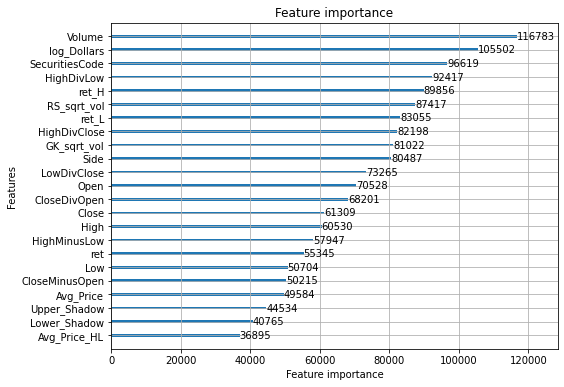

In [17]:
model_o = optimize_LGBM()
# Shouldnt be x_train, y_train
model_o.fit(X,y)
val_preds = model_o.predict(X_val)
val_score = np.sqrt(mean_squared_error(y_val, val_preds))
print(val_score)
model=model_o

import lightgbm
lightgbm.plot_importance(model, figsize=(8,6));

## Submission

In [18]:
def set_rank(sample_prediction):
    sample_prediction = sample_prediction.sort_values(by = "Prediction", ascending=False)
    sample_prediction['Rank'] = np.arange(0,2000)
    sample_prediction = sample_prediction.sort_values(by = "SecuritiesCode", ascending=True)
    return sample_prediction

In [19]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

df = pd.DataFrame(columns=prices.columns)

for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    X = preprocess(prices)
    
    sample_prediction["Prediction"] = model.predict(X)
    
    sample_prediction = set_rank(sample_prediction)
#     sample_prediction = sample_prediction.sort_values(by = "Prediction", ascending=False)
#     sample_prediction['Rank'] = np.arange(0,2000)
#     sample_prediction = sample_prediction.sort_values(by = "SecuritiesCode", ascending=True)
    sample_prediction = sample_prediction.drop(["Prediction"],axis=1)
    submission = sample_prediction[["Date","SecuritiesCode","Rank"]]
    env.predict(submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# import numpy as np
# import jpx_tokyo_market_prediction
# env = jpx_tokyo_market_prediction.make_env()
# iter_test = env.iter_test()

# counter = 0
# # The API will deliver six dataframes in this specific order:
# for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
#     df = df.append(preprocess(prices))
#     print(df.shape)
#     print(prices)
#     print(prices['Date'].min())
#     sample_prediction['Rank'] = np.arange(len(sample_prediction))
#     env.predict(sample_prediction)
#     counter += 1